## 卷积神经网络（Convolutional Neural Network, CNN）
## 项目：实现一个狗品种识别算法App

在这个notebook文件中，有些模板代码已经提供给你，但你还需要实现更多的功能来完成这个项目。除非有明确要求，你无须修改任何已给出的代码。以**'(练习)'**开始的标题表示接下来的代码部分中有你必须要实现的功能。每一部分都会有详细的指导，需要实现的部分也会在注释中以'TODO'标出。请仔细阅读所有的提示！

除了实现代码外，你还**必须**回答一些与项目和你的实现有关的问题。每一个需要你回答的问题都会以**'问题 X'**为标题。请仔细阅读每个问题，并且在问题后的**'回答'**文字框中写出完整的答案。我们将根据你对问题的回答和撰写代码所实现的功能来对你提交的项目进行评分。

>**提示：**Code 和 Markdown 区域可通过 **Shift + Enter** 快捷键运行。此外，Markdown可以通过双击进入编辑模式。

项目中显示为_选做_的部分可以帮助你的项目脱颖而出，而不是仅仅达到通过的最低要求。如果你决定追求更高的挑战，请在此IPython notebook中完成_选做_部分的代码。

---
### 让我们开始吧
在这个notebook中，你将迈出第一步，来开发可以作为移动端或Web应用程序的一部分的算法。在这个项目的最后，你的程序将能够把用户提供的任何一个图像作为输入。如果可以从图像中检测到一只狗，它会输出对狗品种的预测。如果图像中是一个人脸，它会预测一个与其最相似的狗的种类。下面这张图展示了完成项目后可能的输出结果。（……实际上我们希望每个学生的输出结果不相同！）

![Sample Dog Output](images/sample_dog_output.png)

在现实世界中，你需要拼凑一系列的模型来完成不同的任务；举个例子，用来预测狗种类的算法会与预测人类的算法不同。在做项目的过程中，你可能会遇到不少失败的预测，因为并不存在完美的算法和模型。你最终提交的不完美的解决方案也一定会给你带来一个有趣的学习经验！

### 前方的道路

我们将这个notebook分为不同的步骤，你可以使用下面的链接来浏览此notebook。

* [Step 0](#step0): 导入数据集
* [Step 1](#step1): 检测人类
* [Step 2](#step2): 检测狗
* [Step 3](#step3): 创建一个CNN来分类狗品种（来自Scratch）
* [Step 4](#step4): 使用一个CNN来区分狗的品种(使用迁移学习)
* [Step 5](#step5): 建立一个CNN来分类狗的品种（使用迁移学习）
* [Step 6](#step6): 完成你的算法
* [Step 7](#step7): 测试你的算法

---
<a id='step0'></a>
## 步骤 0: 导入数据集

### 导入狗数据集
在下方的代码单元（cell）中，我们导入了一个狗图像的数据集。我们使用scikit-learn库中的`load_files`函数来获取一些变量：
- `train_files`, `valid_files`, `test_files` - 包含图像的文件路径的numpy数组
- `train_targets`, `valid_targets`, `test_targets` - 包含独热编码分类标签的numpy数组
- `dog_names` - 由字符串构成的与标签相对应的狗的种类

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# 定义函数来加载train，test和validation数据集
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# 加载train，test和validation数据集
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# 加载狗品种列表
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# 打印数据统计描述
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### 导入人脸数据集

在下方的代码单元中，我们导入人脸图像数据集，文件所在路径存储在`human_files`numpy数组。

In [2]:
import random
random.seed(8675309)

# 加载打乱后的人脸数据集的文件名
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# 打印数据集的统计描述
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## 步骤1：检测人类

我们用OpenCV实现的[Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html)去检测图像中的人脸。OpenCV提供很多预训练的人脸检测模型，它们以XML文件保存在[github](https://github.com/opencv/opencv/tree/master/data/haarcascades)。我们已经下载了其中一个检测模型，并且把它存储在`haarcascades`的目录中。

在下一个代码单元中，我们将演示如何使用这个检测模型在样本图像中找到人脸。

Number of faces detected: 1


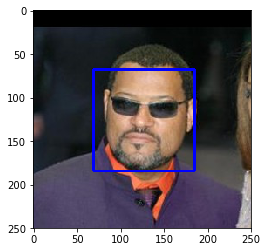

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# 提取预训练的人脸检测模型
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# 加载彩色（通道顺序为BGR）图像
img = cv2.imread(human_files[3])
# 将BGR图像进行灰度化处理
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 在图像中找出脸
faces = face_cascade.detectMultiScale(gray)

# 打印图像中检测到的脸的个数
print('Number of faces detected:', len(faces))

# 获取每一个所检测到的脸的识别框
for (x,y,w,h) in faces:
    # 将识别框添加到彩色图像中
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# 将BGR图像转变为RGB图像以打印
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 展示含有识别框的图像
plt.imshow(cv_rgb)
plt.show()

在使用任何一个检测模型之前，将图像转换为灰度级是常用过程。`detectMultiScale`函数运行保存在`face_cascade`的分类器，并将灰度图像作为一个参数。

在上方的代码中，`faces`是被检测到的脸的numpy数组，其中每一行表示一个被检测到的脸。每一个被检测到的脸都是一个含有4个条目的1维数组，它们表示着被检测到的面部的识别框。数组中的前两个条目（从上方代码中提取出的`x`和`y`）表示着识别框左上角的水平和垂直位置。数组中后面的2个条目（提取为`w`和`h`）表示识别框的宽和高。

### 写一个人脸识别器
我们可以用这个程序去写一个函数，在函数中，当能够在图中识别到人脸的时候返回`True`，否则返回`False`。这个函数被巧妙地命名为`face_detector`，将图像所对应的字符串路径作为输入，并显示在下方代码块中。

In [4]:
# 如果img_path路径表示的图像检测到了脸，返回"True" 
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (练习) 评估人脸检测模型

__问题 1:__ 使用下方代码单元来测试`face_detector`函数的表现  
- `human_files`的前100张图像中，能够检测到**人脸**的图像占比多少？
- `dog_files`的前100张图像中，能够检测到**人脸**的图像占比多少？

理想情况下，人图像中检测到人脸的概率应当为100%，而狗图像中检测到人脸的概率应该为0%。你会发现我们的算法并不如愿，但结果仍然是可以接受的。我们从每个数据集中提取前100个图像的文件路径，并将它们存储在`human_files_short`和`dog_files_short`中。


__回答:__ 99%和11%

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# 请不要修改上方代码

## TODO: 测试face_detector的表现
## 通过human_files_short和dog_files_short中的图像
count_human = 0
count_dog = 0
for ele in human_files_short:
    if face_detector(ele):
        count_human += 1
for ele in dog_files_short:
    if face_detector(ele):
        count_dog += 1
        
print ('{:.2f}% percent of the first 100 images in human_files have a detected human face'\
       .format(count_human/len(human_files_short)*100))
print ('{:.2f}% percent of the first 100 images in dog_files have a detected human face'\
       .format(count_dog/len(dog_files_short)*100))

99.00% percent of the first 100 images in human_files have a detected human face
11.00% percent of the first 100 images in dog_files have a detected human face


__问题 2:__ 这个算法的关键在于我们需要用户提供含有清晰面部特征的人图像（否则结果就会不尽如意）。那么你认为这是对客户的合理要求与期望吗？如果你觉得不合理，你能否想到一个方法，即使图像中并没有清晰的面部特征，也能够检测到人脸？

__回答:__需要清晰的图像对于客户来说并不是合理的要求，因为客户提供的图片清晰度不同，清晰与不清晰的界限是模糊的。可以使用卷积神经网络对人脸图片进行学习，最终能够识别人脸。

我们建议在你的算法中使用opencv的人脸检测模型去检测人类图像，不过你可以自由地探索其他的方法，尤其是尝试使用深度学习来解决它:)。请用下方的代码单元来设计和测试你的面部监测算法。如果你决定完成这个_选做_任务，你需要报告算法在每一个数据集上的表现。

In [6]:
## (选做) TODO: 报告另一个面部检测算法在LFW数据集上的表现
### 你可以随意使用所需的代码单元数

---
<a id='step2'></a>
## 步骤 2: 检测狗

在这个部分中，我们使用预训练的[ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006)模型去检测图像中的狗。下方的第一行代码就是下载ResNet-50模型，包括已训练的[ImageNet](http://www.image-net.org/)权重。ImageNet这是一个很大很流行的数据集，常被用来做图像分类或者其他的计算机视觉任务。它包含一千万以上的URLs，每一个都链接到[1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)中所对应的一个物体的图像。输入一个图像，这个预训练的ResNet-50模型会返回一个对图像中物体的预测结果（来自ImageNet中可用的类别）。

In [7]:
from keras.applications.resnet50 import ResNet50

# 定义ResNet50模型
ResNet50_model = ResNet50(weights='imagenet')

### 数据预处理

在使用 TensorFlow 作为后端的时候，在 Keras 中，CNN 的输入是一个4维数组（也被称作4维张量），格式如下

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

其中`nb_samples`表示图像（或者样本）的总数，`rows`, `columns`, 和 `channels`分别表示图像的行数、列数和通道。

下方的`path_to_tensor`函数将彩色图像的字符串型的文件路径作为输入，返回一个4维张量，作为Keras CNN输入。该函数先加载图像，然后将其调整为224×224像素大小。接着，图像就被转化为了将被调整为4维张量的数组。在这个情况下，即使我们正在处理的是彩色的图像，每个图像也是有3个通道。同样的，即使我们正在处理一个单一图像（或者样本），返回的张量的格式一定为

$$
(1, 224, 224, 3).
$$

`paths_to_tensor`函数将图像路径的字符串组成的numpy数组作为输入，并返回一个4维张量，格式为

$$
(\text{nb_samples}, 224, 224, 3).
$$

在这里，`nb_samples`是提供的图像路径的数据中的样本数量或图像数量。最好是把`nb_samples`作为数据集中3维张量的个数（每个3维张量表示一个不同的图像）！

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # 加载RGB图像为PIL.Image.Image类型
    img = image.load_img(img_path, target_size=(224, 224))
    # 将PIL.Image.Image类型转化为格式为(224, 224, 3)的3维张量
    x = image.img_to_array(img)
    # 将3维张量转化为格式为(1, 224, 224, 3)的4维张量并返回
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### 使用ResNet-50做预测

想要得到 resnet-50 的四维张量，或者 Keras 上其他预训练模型，都需要一些额外的处理。Inception V3、Xception、InceptionResNetV2 的权值是用 TensorFlow 训练出来的，所以需要进行归一化，即缩放到 (-1, 1)，通道顺序是 RGB，其他的模型比如VGG16、VGG19、ResNet50的权值是从 Caffe 转过来的，预处理方法是减 ImageNet 均值，即从每个图像的每个像素中减去平均像素（在 BGR 表示为 `[103.939, 116.779, 123.68]`，并从 ImageNet 中所有图像的像素中计算得到），通道顺序是 BGR。`preprocess_input`函数实现了该功能。如果你对此很感兴趣，可以在 [这里](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py) 查看 `preprocess_input`的代码。

在实现了图像处理的部分之后，我们就可以使用模型来进行预测。这一步通过 `predict` 方法来实现，它返回一个向量，向量的第i个元素表示该图像属于第i个ImageNet类别的概率。这通过如下的 `ResNet50_predict_labels` 函数实现。

通过对预测出的向量（）取用 argmax 函数（找到有最大概率值的下标序号），我们可以得到一个整数，即模型预测到的物体的类别。进而根据这个 [清单](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)，我们能够知道这具体是哪个品种的狗狗。


In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions
def ResNet50_predict_labels(img_path):
    # 返回img_path路径的图像的预测向量
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### 完成狗检测模型


在研究该 [清单](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) 的时候，你会注意到，狗类别对应的序号为151-268。因此，在检查预训练模型判断图像是否包含狗的时候，我们只需要检查如上的 `ResNet50_predict_labels` 函数是否返回一个介于151和268之间（包含区间端点）的值。

我们通过这些想法来完成下方的`dog_detector`函数，如果从图像中检测到狗就返回`True`，否则返回`False`。

In [10]:
### 如果img_path中的图像可以检测到狗，就返回True" 
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__问题 3:__ 使用下方代码单元来测试你所完成的`dog_detector`函数的表现力。
- `human_files_short`中图像检测到狗的百分比？
- `dog_files_short`中图像检测到狗的百分比？

__回答:__ 1%和100%

In [11]:
### TODO: 测试dog_detector函数在human_files_short和dog_files_short的表现
count_dog_in_human = 0
count_dog_in_dog = 0
for ele in human_files_short:
    if dog_detector(ele):
        count_dog_in_human+=1
for ele in dog_files_short:
    if dog_detector(ele):
        count_dog_in_dog+=1

print('{}%'.format(count_dog_in_human/len(human_files_short)*100))
print('{}%'.format(count_dog_in_dog/len(dog_files_short)*100))

1.0%
100.0%


---
<a id='step3'></a>
## 步骤 3: 创建一个CNN来分类狗品种（来自Scratch）


现在我们已经实现了一个函数，能够在图像中识别人类及狗狗。但我们需要更进一步的方法，来对狗的类别进行识别。在这一步中，你需要实现一个卷积神经网络来对狗的品种进行分类。你需要__从头实现__你的卷积神经网络（在这一阶段，你还不能使用迁移学习），并且你需要达到超过1%的测试集准确率。在本项目的步骤五种，你还有机会使用迁移学习来实现一个准确率大大提高的模型。

在添加卷积层的时候，注意不要加上太多的可训练的层。更多的参数意味着更长的训练时间，也就是说你更可能需要一个 GPU 来加速训练过程。万幸的是，Keras 提供了能够轻松预测每次迭代（epoch）花费时间所需的函数。你可以据此推断你算法所需的训练时间。

值得注意的是，对狗的图像进行分类是一项极具挑战性的任务。因为即便是一个正常人，也很难区分布列塔尼犬和威尔士史宾格犬。


布列塔尼犬（Brittany） | 威尔士史宾格犬（Welsh Springer Spaniel）
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

不难发现其他的狗品种会有很小的类间差别（比如金毛寻回犬和美国水猎犬）。


金毛寻回犬（Curly-Coated Retriever） | 美国水猎犬（American Water Spaniel）
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">

同样，拉布拉多犬（labradors）有黄色、棕色和黑色这三种。那么你设计的基于视觉的算法将不得不克服这种较高的类间差别，以达到能够将这些不同颜色的同类狗分到同一个品种中。

黄色拉布拉多犬（Yellow Labrador） | 棕色拉布拉多犬（Chocolate Labrador） | 黑色拉布拉多犬（Black Labrador）
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

我们也提到了随机分类将得到一个非常低的结果：不考虑品种略有失衡的影响，随机猜测到正确品种的概率是1/133，相对应的准确率是低于1%的。

请记住，在深度学习领域，实践远远高于理论。大量尝试不同的框架吧，相信你的直觉！当然，玩得开心！

### 数据预处理


通过对每张图像的像素值除以255，我们对图像实现了归一化处理。

In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
print(len(train_files),len(valid_files),len(test_files))
# Keras中的数据预处理过程
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255
train_tensors = paths_to_tensor(train_files).astype('float32')/255

6680 835 836


100%|██████████████████████████████████████████████████████████████████████████████| 6680/6680 [01:19<00:00, 83.56it/s]


In [13]:
print(test_tensors.shape[1:])

(224, 224, 3)


In [14]:
print(train_tensors.shape)

(6680, 224, 224, 3)


### (练习) 模型架构


创建一个卷积神经网络来对狗品种进行分类。在你代码块的最后，通过执行 `model.summary()` 来输出你模型的总结信息。
    
我们已经帮你导入了一些所需的 Python 库，如有需要你可以自行导入。如果你在过程中遇到了困难，如下是给你的一点小提示——该模型能够在5个 epoch 内取得超过1%的测试准确率，并且能在CPU上很快地训练。

![Sample CNN](images/sample_cnn.png)
           
__问题 4:__ 列出你得到最终的卷积神经网络模型的步骤，并且说出你每个步骤的原因。如果你选用了提示的架构，请说明为何如上的架构能够在该问题上取得很好的表现。

__回答:__首先创建一卷积层，用16个过滤窗来提取简单基本特征，使用最大池化层防止卷积层提取出来的特征图片与原图片大小相同，之后分别用32和64个过滤窗作为卷积层参数来提取高级复杂特征，卷积层间添加最大池化层来缩小特征图片大小，然后使用全局平均池化层将三维数组转化成向量，并与具有133个节点的softmax全连接层相连。由于是狗品种分类器，图片边缘并没有有效特征，卷积层就没有填充边缘。

In [15]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: 定义架构
model.add(Conv2D(filters=16, kernel_size=2, padding='valid', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### 编译模型

In [16]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (练习) 训练模型

在下方代码单元训练模型。使用模型检查点（model checkpointing）来储存具有最低验证集 loss 的模型。

当然，你也可以对训练集进行 [数据增强](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)，不过这不是必须的步骤。



In [17]:
from keras.callbacks import ModelCheckpoint  

In [18]:
from keras.callbacks import ModelCheckpoint  
### TODO: 设置训练模型的epochs的数量

epochs = 5

### 不要修改下方代码

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 237s - loss: 4.8850 - acc: 0.0091 - val_loss: 4.8717 - val_acc: 0.0108
Epoch 2/5
6680/6680 [==============================] - 236s - loss: 4.8647 - acc: 0.0117 - val_loss: 4.8573 - val_acc: 0.0108
Epoch 3/5
6680/6680 [==============================] - 230s - loss: 4.8309 - acc: 0.0150 - val_loss: 4.8243 - val_acc: 0.0156
Epoch 4/5
6680/6680 [==============================] - 235s - loss: 4.7865 - acc: 0.0207 - val_loss: 4.7945 - val_acc: 0.0192
Epoch 5/5
6680/6680 [==============================] - 227s - loss: 4.7526 - acc: 0.0211 - val_loss: 4.7878 - val_acc: 0.0251


### 加载具有最好验证loss的模型

In [19]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### 测试模型

在狗图像的测试数据集上试用你的模型。确保测试准确率大于1%。

In [20]:
# 获取测试数据集中每一个图像所预测的狗品种的index
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# 报告测试准确率
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 2.5120%


---
<a id='step4'></a>
## 步骤 4: 使用一个CNN来区分狗的品种

为了在不损失准确率的情况下减少训练时间，我们可以使用迁移学习来训练CNN。在以下步骤中，你可以尝试使用迁移学习来训练你自己的CNN。

### 得到从图像中提取的特征向量（Bottleneck Features）

In [21]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### 模型架构

该模型使用预训练的 VGG-16 模型作为固定的图像特征提取器，其中 VGG-16 最后一层卷积层的输出被直接输入到我们的模型。我们只需要添加一个全局平均池化层以及一个全连接层，其中全连接层使用 softmax 激活函数，对每一个狗的种类都包含一个节点。

In [22]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### 编译模型

In [23]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### 训练模型

In [24]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s - loss: 12.2504 - acc: 0.1247 - val_loss: 10.9555 - val_acc: 0.1952
Epoch 2/20
6680/6680 [==============================] - 3s - loss: 10.1132 - acc: 0.2862 - val_loss: 9.9187 - val_acc: 0.2922
Epoch 3/20
6680/6680 [==============================] - 3s - loss: 9.5111 - acc: 0.3467 - val_loss: 9.8186 - val_acc: 0.3078
Epoch 4/20
6680/6680 [==============================] - 2s - loss: 9.3158 - acc: 0.3802 - val_loss: 9.7292 - val_acc: 0.3257
Epoch 5/20
6680/6680 [==============================] - 3s - loss: 9.2384 - acc: 0.3972 - val_loss: 9.6512 - val_acc: 0.3449
Epoch 6/20
6680/6680 [==============================] - 2s - loss: 9.1843 - acc: 0.4087 -

### 加载具有最好验证loss的模型

In [25]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### 测试模型
现在，我们可以测试此CNN在狗图像测试数据集中识别品种的效果如何。我们在下方打印出测试准确率。

In [26]:
# 获取测试数据集中每一个图像所预测的狗品种的index
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# 报告测试准确率
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 42.9426%


### 使用模型预测狗的品种

In [27]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # 提取bottleneck特征
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # 获取预测向量
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # 返回此模型预测的狗的品种
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## 步骤 5: 建立一个CNN来分类狗的品种（使用迁移学习）

现在你将使用迁移学习来建立一个CNN，从而可以从图像中识别狗的品种。你的CNN在测试集上的准确率必须至少达到60%。

在步骤4中，我们使用了迁移学习来创建一个使用VGG-16 bottleneck特征的CNN。在本部分内容中，你必须使用另一个预训练模型的bottleneck特征。为了让这个任务更易实现，我们已经预先为目前keras中所有可用的网络计算了特征。
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

这些文件被编码为：

    Dog{network}Data.npz

其中`{network}`指上方文件名`VGG19`、`Resnet50`、`InceptionV3`或`Xception`中的一个。选择上方架构中的一个，下载相对应的bottleneck特征，并将所下载的文件保存在目录`bottleneck_features/`中。


### (练习) 获取Bottleneck特征

在下方代码块中，通过运行下方代码提取训练、测试与验证集相对应的bottleneck特征。

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [28]:
### TODO: 从另一个预训练的CNN获取bottleneck特征
bottleneck_features = np.load('bottleneck_features/DogVGG19Data.npz')
train_VGG19 = bottleneck_features['train']
valid_VGG19 = bottleneck_features['valid']
test_VGG19 = bottleneck_features['test']

### (练习) 模型架构

建立一个CNN来分类狗品种。在你的代码单元块的最后，通过运行下一行来总结模型的层次：
    
        <your model's name>.summary()
   
__问题 5:__ 概述你达成最终CNN框架的步骤，以及每一步的原因。并描述你认为该框架适合目前问题的原因。

__回答:__ 将最大池化层和全连接层替换为与新数据集类型数量相匹配的层，随机初始化其权重。剩余权重初始化为先前权重。由于VGG19已经训练好了图片分类的网络，我们要保留其全连接层之前的所有学习到的图像特征，并对新全连接层进行训练，就可以满足个人对图片分类的要求。



In [29]:
### TODO: 定义你的框架
VGG19_model = Sequential()
VGG19_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG19_model.add(Dense(256, activation='relu'))
VGG19_model.add(Dense(133, activation='softmax'))

VGG19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 133)               34181     
Total params: 165,509.0
Trainable params: 165,509.0
Non-trainable params: 0.0
_________________________________________________________________


### (练习) 编译模型

In [30]:
### TODO: 编译模型
VGG19_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (练习) 训练模型

在下方代码单元中训练你的模型。使用模型检查点（model checkpointing）来储存具有最低验证集 loss 的模型。

当然，你也可以对训练集进行 [数据增强](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)，不过这不是必须的步骤。


In [31]:
### TODO: 训练模型
VGG19_checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG19.hdf5', 
                               verbose=1, save_best_only=True)

VGG19_model.fit(train_VGG19, train_targets, 
          validation_data=(valid_VGG19, valid_targets),
          epochs=20, batch_size=20, callbacks=[VGG19_checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 4s - loss: 3.1730 - acc: 0.4078 - val_loss: 1.5814 - val_acc: 0.5784
Epoch 2/20
6680/6680 [==============================] - 3s - loss: 0.9793 - acc: 0.7322 - val_loss: 1.3954 - val_acc: 0.6743
Epoch 3/20
6680/6680 [==============================] - 3s - loss: 0.6285 - acc: 0.8243 - val_loss: 1.3674 - val_acc: 0.7257
Epoch 4/20
6680/6680 [==============================] - 3s - loss: 0.4304 - acc: 0.8804 - val_loss: 1.4378 - val_acc: 0.7234
Epoch 5/20
6680/6680 [==============================] - 3s - loss: 0.3340 - acc: 0.9046 - val_loss: 1.6730 - val_acc: 0.7210
Epoch 6/20
6680/6680 [==============================] - 3s - loss: 0.2650 - acc: 0.9265 - val_

### (练习) 加载具有最好验证loss的模型

In [32]:
### TODO: 加载具有最佳验证loss的模型权重
VGG19_model.load_weights('saved_models/weights.best.VGG19.hdf5')

### (练习) 测试模型

在狗图像的测试数据集上试用你的模型。确保测试准确率大于60%。

In [33]:
### TODO: 在测试集上计算分类准确率
VGG19_predictions = [np.argmax(VGG19_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG19]

VGG19_test_accuracy = 100*np.sum(np.array(VGG19_predictions)==np.argmax(test_targets, axis=1))/len(VGG19_predictions)
print('Test accuracy: %.4f%%' % VGG19_test_accuracy)

Test accuracy: 69.3780%


### (练习) 使用模型测试狗的品种


实现一个函数，它的输入为图像路径，功能为预测对应图像的类别，输出为你模型预测出的狗类别（`Affenpinscher`, `Afghan_hound`等）。

与步骤5中的模拟函数类似，你的函数应当包含如下三个步骤：

1. 根据选定的模型提取图像特征（bottleneck features）
2. 将图像特征输输入到你的模型中，并返回预测向量。注意，在该向量上使用 argmax 函数可以返回狗种类的序号。
3. 使用在步骤0中定义的 `dog_names` 数组来返回对应的狗种类名称。

提取图像特征过程中使用到的函数可以在 `extract_bottleneck_features.py` 中找到。同时，他们应已在之前的代码块中被导入。根据你选定的 CNN 网络，你可以使用 `extract_{network}` 函数来获得对应的图像特征，其中 `{network}` 代表 `VGG19`, `Resnet50`, `InceptionV3`, 或 `Xception` 中的一个。
 

In [34]:
### TODO: 写一个函数，该函数将图像的路径作为输入
### 然后返回此模型所预测的狗的品种
def VGG19_predict_breed(img_path):
    # 提取bottleneck特征
    bottleneck_feature = extract_VGG19(path_to_tensor(img_path))#4维张量
    predicted_vector = VGG19_model.predict(bottleneck_feature)
    # 返回此模型预测的狗的品种
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## 步骤 6: 完成你的算法


实现一个算法，它的输入为图像的路径，它能够区分图像是否包含一个人、狗或都不包含，然后：

- 如果从图像中检测到一只__狗__，返回被预测的品种。
- 如果从图像中检测到__人__，返回最相像的狗品种。
- 如果两者都不能在图像中检测到，输出错误提示。

我们非常欢迎你来自己编写检测图像中人类与狗的函数，你可以随意地使用上方完成的`face_detector`和`dog_detector`函数。你__需要__在步骤5使用你的CNN来预测狗品种。

下面提供了算法的示例输出，但你可以自由地设计自己的模型！

![Sample Human Output](images/sample_human_output.png)


### (练习) 完成你的算法

In [35]:
### TODO: 设计你的算法
### 自由地使用所需的代码单元数吧
def img_detector(img_path):
    if dog_detector(img_path):
        dog_name = VGG19_predict_breed(img_path)
        pic_bgr = cv2.imread(img_path)
        pic_rgb = cv2.cvtColor(pic_bgr, cv2.COLOR_BGR2RGB)
        plt.imshow(pic_rgb)
        plt.show()
        print('The breed of this dog is ' + dog_name)
    elif face_detector(img_path):
        similar_dog_name = VGG19_predict_breed(img_path)
        pic_bgr = cv2.imread(img_path)
        pic_rgb = cv2.cvtColor(pic_bgr, cv2.COLOR_BGR2RGB)
        plt.imshow(pic_rgb)
        plt.show()
        print('This human looks like '+ similar_dog_name)
    else:
        pic_bgr = cv2.imread(img_path)
        pic_rgb = cv2.cvtColor(pic_bgr, cv2.COLOR_BGR2RGB)
        plt.imshow(pic_rgb)
        plt.show()
        print('Unable to detect')
        return False

---
<a id='step7'></a>
## 步骤 7: 测试你的算法

在这个部分中，你将尝试一下你的新算法！算法认为__你__看起来像什么类型的狗？如果你有一只狗，它可以准确地预测你的狗的品种吗？如果你有一只猫，它会将你的猫误判为一只狗吗？

### (练习) 在样本图像上测试你的算法！

在你的电脑上，用至少6张图片来测试你的算法。请自由地使用任何一张你想用的图片。不过请至少使用两张人类图片和两张狗的图片。

__问题 6:__ 输出结果比你预想的要好吗 :) ？或者更糟 :( ？请提出至少三点改进你的模型的方法。

__回答:__ 输出结果比我预想的要好些，改进：一、增加dropout层。二、适当增加隐藏层，若准确度降低则停止。三、改变batch_size

['P2_test/u=1033835092,1129982456&fm=27&gp=0.jpg', 'P2_test/u=1059036364,2388686104&fm=200&gp=0.jpg', 'P2_test/u=2158114774,3687302370&fm=27&gp=0.jpg', 'P2_test/u=265513954,4001658868&fm=27&gp=0.jpg', 'P2_test/u=285934200,1505524386&fm=27&gp=0.jpg', 'P2_test/u=3064882181,1815717679&fm=27&gp=0.jpg', 'P2_test/u=3680166269,2100915600&fm=27&gp=0.jpg', 'P2_test/u=3934421261,2964554617&fm=27&gp=0.jpg']


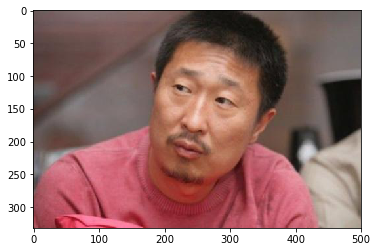

This human looks like Chihuahua


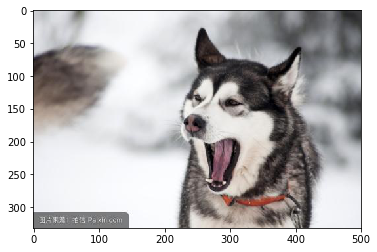

The breed of this dog is Alaskan_malamute


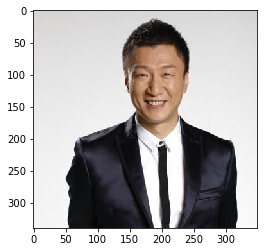

This human looks like Belgian_sheepdog


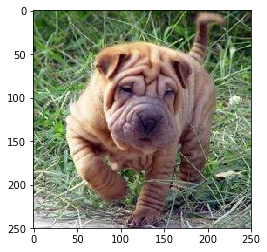

The breed of this dog is Chinese_shar-pei


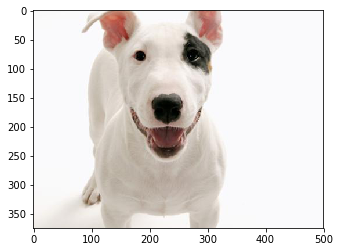

The breed of this dog is Bull_terrier


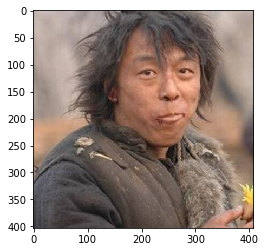

The breed of this dog is Dogue_de_bordeaux


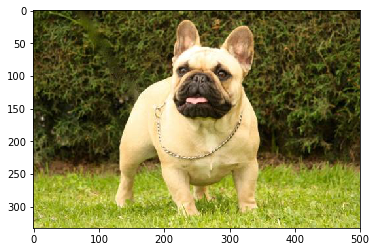

The breed of this dog is French_bulldog


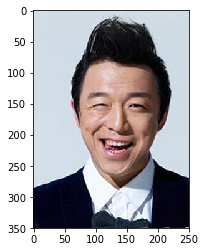

This human looks like Silky_terrier


In [36]:
## TODO: 在你的电脑上，在步骤6中，至少在6张图片上运行你的算法。
## 自由地使用所需的代码单元数吧
import os
def file_name(file_dir):   
    for root, dirs, files in os.walk(file_dir):  
        return files
pics = file_name('P2_test')
L=[]
for i in pics:
    L.append('P2_test'+'/'+i)
print(L)
for ele in L:
    img_detector(ele)

**注意: 当你写完了所有的代码，并且回答了所有的问题。你就可以把你的 iPython Notebook 导出成 HTML 文件。你可以在菜单栏，这样导出File -> Download as -> HTML (.html)把这个 HTML 和这个 iPython notebook 一起做为你的作业提交。**